In [56]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy as sc
from scipy import io
from IPython import display
import time
from scipy.stats import multivariate_normal

from sklearn.metrics import mean_squared_error
from sklearn.cross_decomposition import PLSRegression

from sklearn.decomposition import PCA

from matplotlib import rc
from matplotlib.patches import Ellipse
rc('text', usetex=True)

%config InlineBackend.figure_format = 'retina'

In [57]:
np.random.seed(58)

x_mean = np.array([0., 0.])
x_cov = np.array([[.25, .2],
                 [.2, .3]])
size=1000
X = np.random.multivariate_normal(x_mean, x_cov, size)
X = (X - X.mean(axis=0)) / X.std(axis=0)

y_mean = np.array([0., 0.])
y_cov = np.array([[.25, -0.2],
                 [-0.2, .3]])
Y = np.random.multivariate_normal(y_mean, y_cov, size)
Y = (Y - Y.mean(axis=0)) / Y.std(axis=0)

In [58]:
x_pca = PCA(n_components=2)
x_pca.fit(X)
x_comps = x_pca.components_

y_pca = PCA(n_components=2)
y_pca.fit(Y)
y_comps = y_pca.components_

x_h, x_w = x_pca.explained_variance_
y_h, y_w = y_pca.explained_variance_

pls = PLSRegression()
pls.fit(X, Y)

PLSRegression(copy=True, max_iter=500, n_components=2, scale=True, tol=1e-06)

In [59]:
x_angle = 90 + np.arcsin(x_comps[0][0]) * 180 / np.pi
y_angle = np.arcsin(y_comps[0][0]) * 180 / np.pi

In [60]:
W = pls.x_weights_.T
C = pls.y_weights_.T
T = pls.x_scores_.T
U = pls.y_scores_.T

t_proj_0 = T[0] * W[0][0]
t_proj_1 = T[0] * W[0][1]

u_proj_0 = U[0] * C[0][0]
u_proj_1 = U[0] * C[0][1]

C = (C.T / sc.linalg.norm(C.T, axis=0)).T 

In [61]:
idxs = []
for i in range(len(X)):
    x_prob = multivariate_normal.pdf(X[i], x_mean, x_cov)
    y_prob = multivariate_normal.pdf(Y[i], y_mean, y_cov)
    if x_prob > 0.3 and y_prob > 0.3 and x_prob < 0.95 and y_prob < 0.95:
        idxs.append(i)

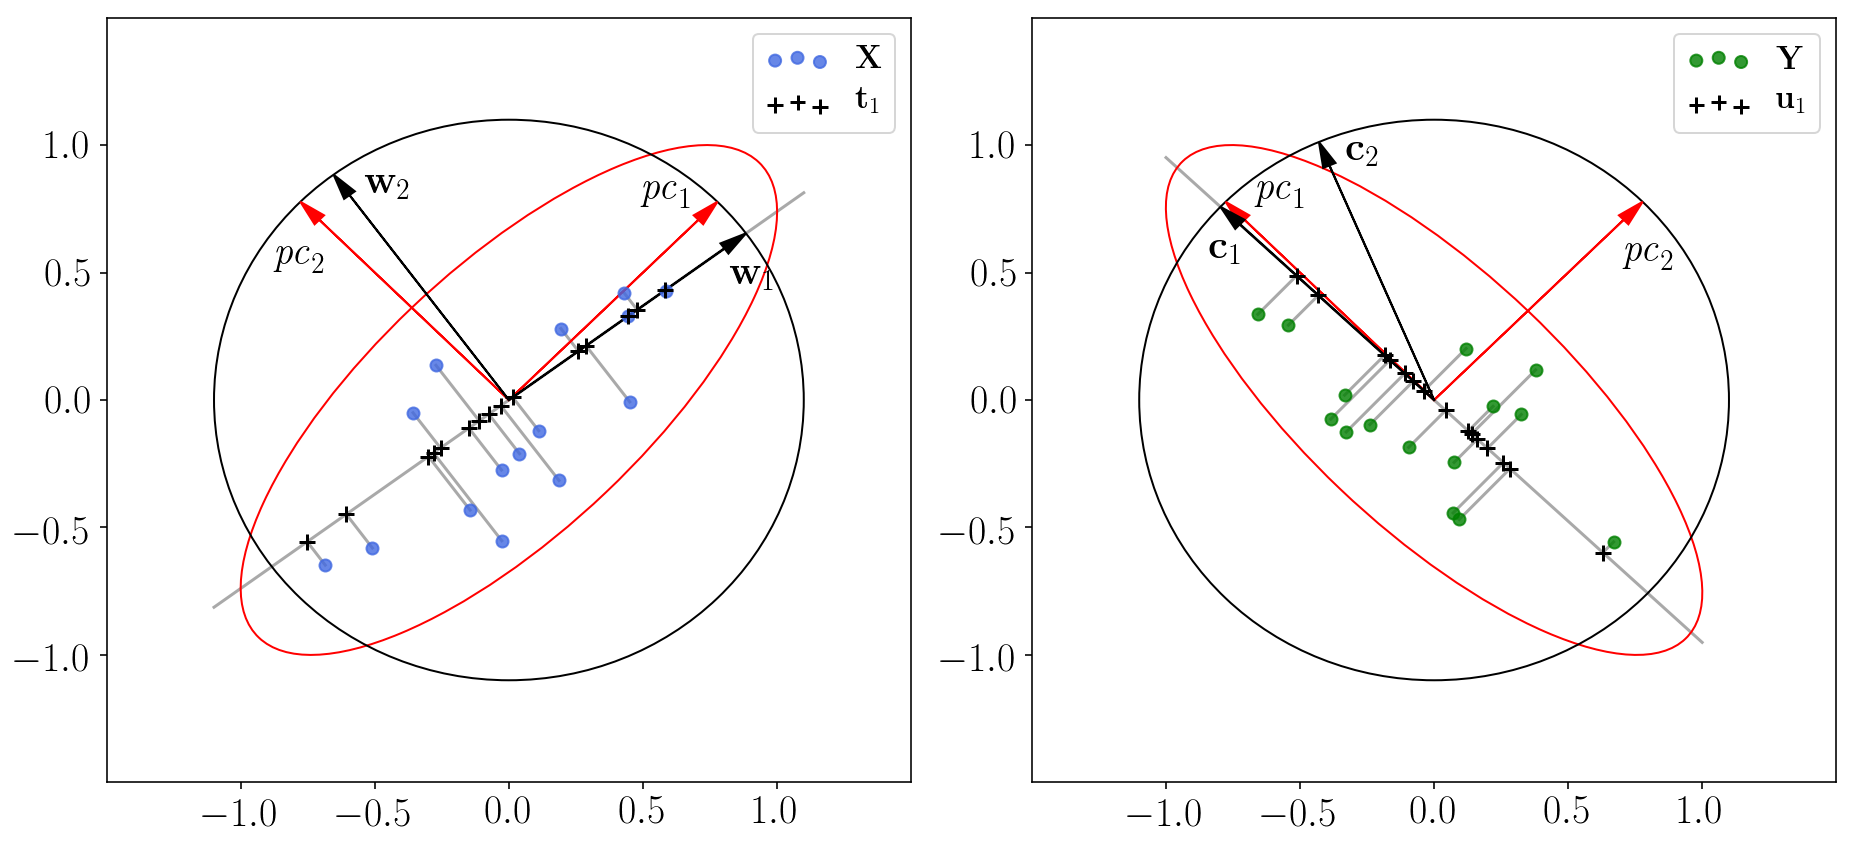

In [66]:
r = 2.2
k = 2
idx_1, idx_2 = 15, 30

x_ellipse = Ellipse([0., 0], height=k * np.sqrt(x_w) , width = k * np.sqrt(x_h), 
                    fill=False, angle=x_angle, color='r')
y_ellipse = Ellipse([0., 0], height=k * np.sqrt(y_h) , width = k * np.sqrt(y_w), 
                    fill=False, angle=y_angle, color='r')
unit_ball1 = Ellipse([0., 0.], height=r, width=r, fill=False, color='k')
unit_ball2 = Ellipse([0., 0.], height=r, width=r, fill=False, color='k')

k_x1 = W[0][1] / W[0][0]
k_x2 = W[1][1] / W[1][0]
x_grid_1 = np.linspace(-1.1, 1.1, 50)
x_grid_2 = np.linspace(-0.7, 0.7, 50)

plt.figure(figsize=(13, 6))
ax = plt.subplot(1, 2, 1)
plt.scatter(X[idxs[idx_1:idx_2], 0], X[idxs[idx_1:idx_2], 1], 
            alpha=0.8, c='royalblue', zorder=2, label='$\mathbf{X}$')
plt.scatter(t_proj_0[idxs[idx_1:idx_2]], t_proj_1[idxs[idx_1:idx_2]], 
            marker='+', c='k', s=60, zorder=3, label='$\mathbf{t}_1$')

for x, t_0, t_1 in zip(X[idxs[idx_1:idx_2]], t_proj_0[idxs[idx_1:idx_2]], t_proj_1[idxs[idx_1:idx_2]]):
    plt.plot([x[0], t_0], [x[1], t_1], c='darkgrey', zorder=1)

ax.plot(x_grid_1, k_x1 * x_grid_1, c='darkgrey', zorder=1)
plt.xlim([-1.5, 1.5])
plt.ylim([-1.5, 1.5])
plt.text(0.82, .43, '$\mathbf{w}_1$', fontsize=20)
plt.text(.49, .75, '$\mathit{pc}_1$', fontsize=20)
plt.text(-0.54, .79, '$\mathbf{w}_2$', fontsize=20)
plt.text(-.88, .5, '$\mathit{pc}_2$', fontsize=20)
ax.add_artist(x_ellipse)
ax.add_artist(unit_ball1)
ax.arrow(0., 0., -x_comps[0][0], -x_comps[0][1], linewidth=1, head_width=0.05, head_length=0.1, color='r')
ax.arrow(0., 0., -x_comps[1][0], -x_comps[1][1], linewidth=1, head_width=0.05, head_length=0.1, color='r')
ax.arrow(0., 0., W[0][0], W[0][1], linewidth=1, head_width=0.05, head_length=0.1, color='k')
ax.arrow(0., 0., W[1][0], W[1][1], linewidth=1, head_width=0.05, head_length=0.1, color='k')
plt.xticks([-1., -0.5, 0., 0.5, 1.], fontsize=20)
plt.yticks([-1., -0.5, 0., 0.5, 1.], fontsize=20)
plt.legend(fontsize=16, scatterpoints = 3)


k_x1 = C[0][1] / C[0][0]
k_x2 = C[1][1] / C[1][0]
x_grid_1 = np.linspace(-1.0, 1.0, 50)
x_grid_2 = np.linspace(-0.5, 0.5, 50)

ax = plt.subplot(1, 2, 2)
line1 = plt.scatter(Y[idxs[idx_1:idx_2], 0], Y[idxs[idx_1:idx_2], 1], 
                    alpha=0.8, c='g', zorder=2, label='$\mathbf{Y}$')
plt.scatter(u_proj_0[idxs[idx_1:idx_2]], u_proj_1[idxs[idx_1:idx_2]], 
            marker='+', c='k', s=60, zorder=3, label='$\mathbf{u}_1$')

for y, u_0, u_1 in zip(Y[idxs[idx_1:idx_2]], u_proj_0[idxs[idx_1:idx_2]], u_proj_1[idxs[idx_1:idx_2]]):
    plt.plot([y[0], u_0], [y[1], u_1], c='darkgrey', zorder=1)

ax.plot(x_grid_1, k_x1 * x_grid_1, c='darkgrey', zorder=1)
plt.xlim([-1.5, 1.5])
plt.ylim([-1.5, 1.5])
plt.text(-0.33, .92, '$\mathbf{c}_2$', fontsize=20)
plt.text(.70, .51, '$\mathit{pc}_2$', fontsize=20)
plt.text(-.84, .53, '$\mathbf{c}_1$', fontsize=20)
plt.text(-.67, .75, '$\mathit{pc}_1$', fontsize=20)
ax.add_artist(y_ellipse)
ax.add_artist(unit_ball2)
ax.arrow(0., 0., -y_comps[0][0], -y_comps[0][1], linewidth=1, head_width=0.05, head_length=0.1, color='r')
ax.arrow(0., 0., -y_comps[1][0], -y_comps[1][1], linewidth=1, head_width=0.05, head_length=0.1, color='r')
ax.arrow(0., 0., C[0][0], C[0][1], linewidth=1, head_width=0.05, head_length=0.1, color='k')
ax.arrow(0., 0., -C[1][0], -C[1][1], linewidth=1, head_width=0.05, head_length=0.1, color='k')
plt.xticks([-1., -0.5, 0., 0.5, 1.], fontsize=20)
plt.yticks([-1., -0.5, 0., 0.5, 1.], fontsize=20)
plt.legend(fontsize=16, scatterpoints = 3)

plt.subplots_adjust()
plt.tight_layout()
plt.savefig('figs/PLSFigure.jpeg', format='jpeg')
plt.show()